# Finding Alpha and Delta

This notebook is for extracting the alpha and delta accurate FRET correction factors from a dataset. You can load in data from a doubly labelled sample and select the donor only and acceptor only populations, or you can load in singly labelled samples and skip to that section.

We would advise checking your data in the FRET Analysis Notebook first (with no corrections) to check that your data is good.

Working from a doubly labelled sample has the disadvantage that only a minority of the bursts will be singly labelled. However, it is arguably more accurate to derive the correction factors from the same data set (or even just the same sample) as it guarantees that the fluorophores are in exactly the same environment in both the determination and application of the parameters.

# Import packages

This may take a minute

In [2]:
from fretbursts import *
sns = init_notebook()
import lmfit
import phconvert
import os
from fretbursts.burstlib_ext import burst_search_and_gate

# Name and Load in data

Name the data file and check it exists, note that it will look for files starting from the folder this notebook is in.

In [3]:
files = ["exampledata/1a1.hdf5", "exampledata/1a2.hdf5",
         "exampledata/1b1.hdf5", "exampledata/1b2.hdf5",
         "exampledata/1c1.hdf5", "exampledata/1c2.hdf5"
        ]

Load in the file, we do not need to set correction factors yet.

You may get warnings that some parameters are not defined in the file, this is fine as they will be defined in this workbook anyway.

This cell also contains code to sort the timestamps as they are loaded. This is because the timestamps are not always saved in chronological order, and this can confuse some of FRETBursts functions.

In [4]:
datasets = []
for file in files:
    datasets.append(loader.photon_hdf5(file))
for dataset in datasets:
    for i in range(0, len(dataset.ph_times_t)): #sorting code
        indices = dataset.ph_times_t[i].argsort()
        dataset.ph_times_t[i], dataset.det_t[i] = dataset.ph_times_t[i][indices], dataset.det_t[i][indices]

# Apply alternation cycle

Here we apply the alternation cycle to the data and assign photons to channels. If the alternation cycle is different from the parameters indicated by the metadata (you can check in the FRET analysis notebook) then unhash the code in this loop and change them.

In [5]:
for dataset in datasets:
    #dataset.add(det_donor_accept = (0, 1),
    #alex_period = 10000,
    #offset = 0,
    #D_ON = (0, 4500),
    #A_ON = (5000, 9500))
    loader.alex_apply_period(dataset)

# Total photons (after ALEX selection):     2,003,013
#  D  photons in D+A excitation periods:    1,141,024
#  A  photons in D+A excitation periods:      861,989
# D+A photons in  D  excitation period:     1,471,746
# D+A photons in  A  excitation period:       531,267

# Total photons (after ALEX selection):     2,067,432
#  D  photons in D+A excitation periods:    1,161,138
#  A  photons in D+A excitation periods:      906,294
# D+A photons in  D  excitation period:     1,501,952
# D+A photons in  A  excitation period:       565,480

# Total photons (after ALEX selection):     3,266,191
#  D  photons in D+A excitation periods:    2,027,118
#  A  photons in D+A excitation periods:    1,239,073
# D+A photons in  D  excitation period:     2,530,526
# D+A photons in  A  excitation period:       735,665

# Total photons (after ALEX selection):     3,189,530
#  D  photons in D+A excitation periods:    1,997,792
#  A  photons in D+A excitation periods:    1,191,738
# D+A photons in  D  exci

# Background Estimation

We background correct all datasets as before

In [6]:
threshold = 1500
recalctime = 300
for dataset in datasets:
    dataset.calc_bg(bg.exp_fit, time_s = recalctime, tail_min_us=(threshold))
    #dplot(dataset, hist_bg, show_fit=True)

 - Calculating BG rates ... [DONE]
 - Calculating BG rates ... [DONE]
 - Calculating BG rates ... [DONE]
 - Calculating BG rates ... [DONE]
 - Calculating BG rates ... [DONE]
 - Calculating BG rates ... [DONE]


# Burst Searching

M = the number of photons to look at at any time
F = the number of times higher than the background the photon rate must be to be considered a burst
L = the number of photons that must be in a burst to be considered a burst

The burst selection then selects only bursts that are size th1 or higher, and lower than th2. add_naa=True ensures acceptor photons under acceptor excitation are encluded in the search.

Here we use an APBS, then select from an all photon count so that we do not bias in S.

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]
 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]
 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]
 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]
 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting 

C:\Users\chp17ba\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


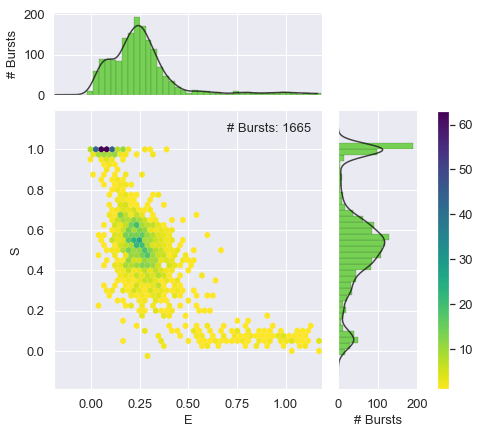

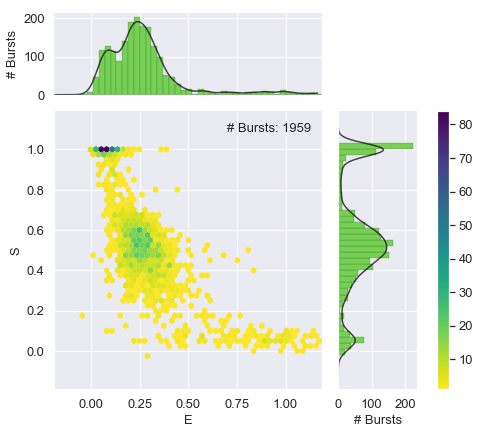

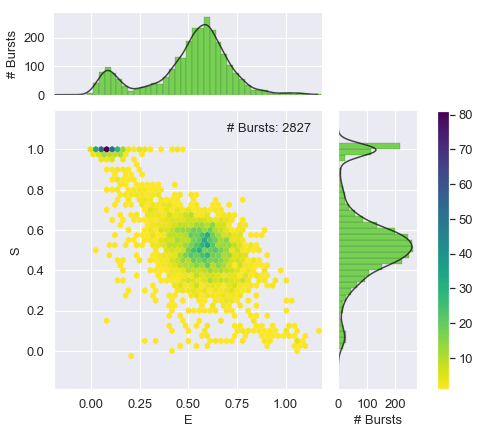

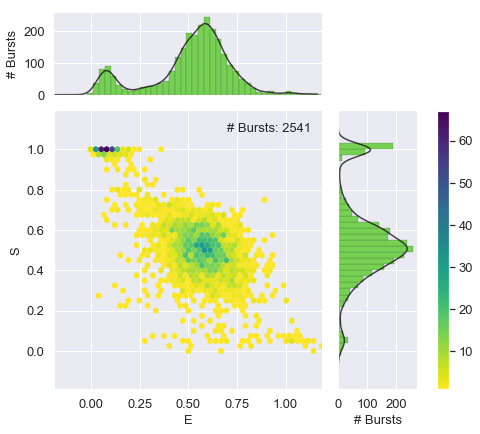

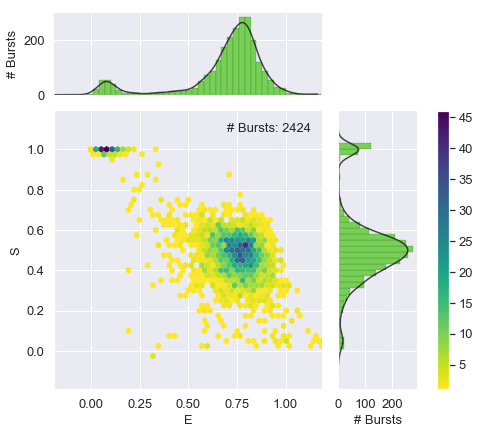

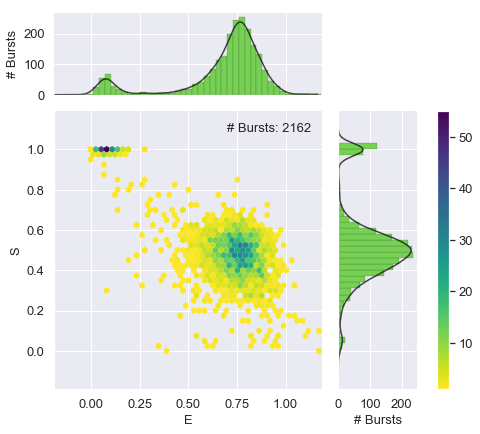

In [7]:
colourscheme= "viridis_r"
burstsets = []
for dataset in datasets:
    dataset.burst_search(L=10, m=10, F=20)
    dataset = dataset.select_bursts(select_bursts.size, add_naa=True, th1=50) #all photons selection
    burstsets.append(dataset)
for burstset in burstsets:
    alex_jointplot(burstset, cmap=colourscheme, marginal_color=20, vmax_fret=False)

# Alpha

Alpha, or the leakage factor, describes the amount of photons emitted by the donor which are detected by the acceptor APD (relative to the donor APD), as a consequence of the red tail of the donor emission spectrum. It can be determined from the apparent FRET efficiency of the donor only population

Now we select the donor only population by drawing a box.

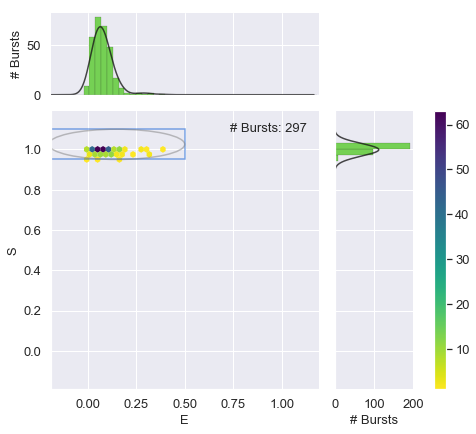

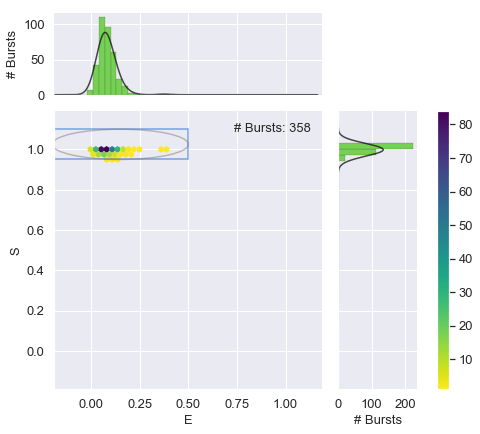

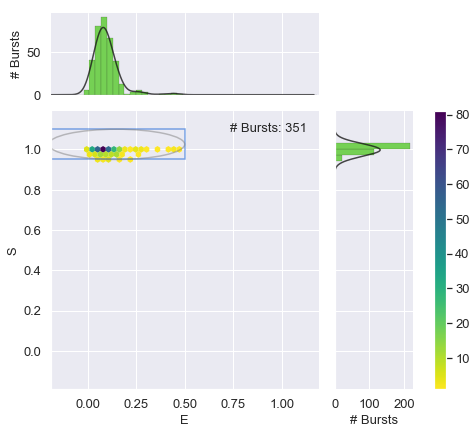

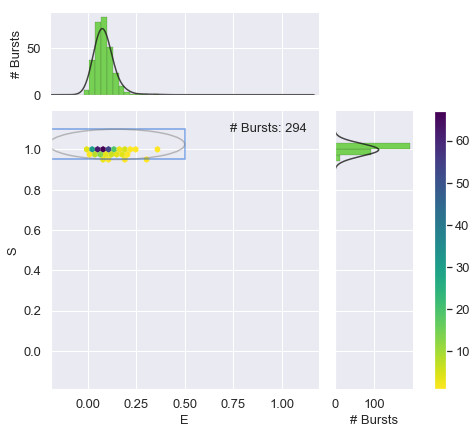

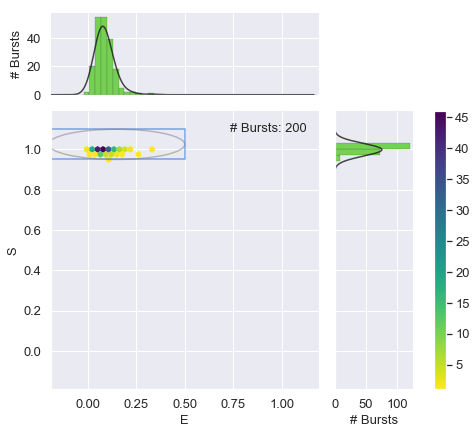

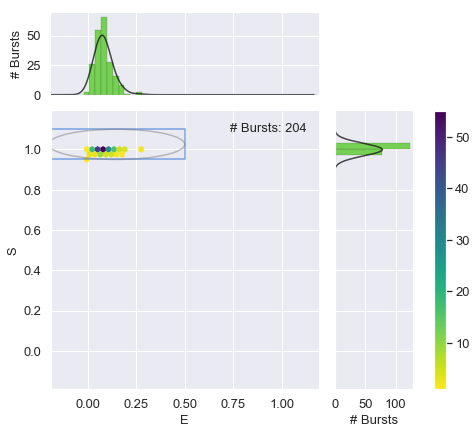

In [8]:
roi= dict(E1=-0.2, E2=0.5, S1=0.95, S2=1.1, rect=True)
donlysets =[]
for burstset in burstsets:
    donoronly = burstset.select_bursts(select_bursts.ES, **roi)
    g = alex_jointplot(donoronly, cmap=colourscheme, marginal_color=20, vmax_fret=False)
    bpl.plot_ES_selection(g.ax_joint, **roi);
    donlysets.append(donoronly)

This will fit a single gaussian to the filtered E, and convert the mean position to an alpha value, the leakage factor

exampledata_1a1 alpha = 0.0728
exampledata_1a2 alpha = 0.0789
exampledata_1b1 alpha = 0.0901
exampledata_1b2 alpha = 0.0828
exampledata_1c1 alpha = 0.0864
exampledata_1c2 alpha = 0.0806


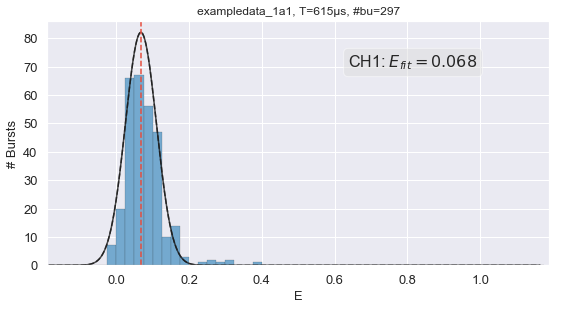

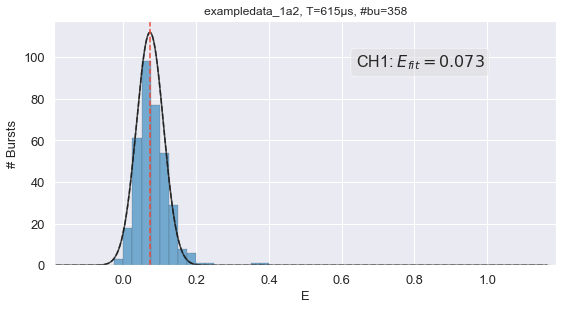

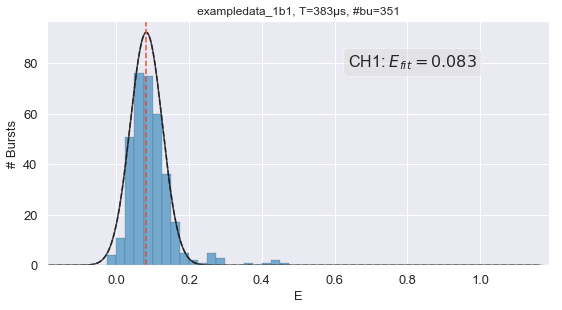

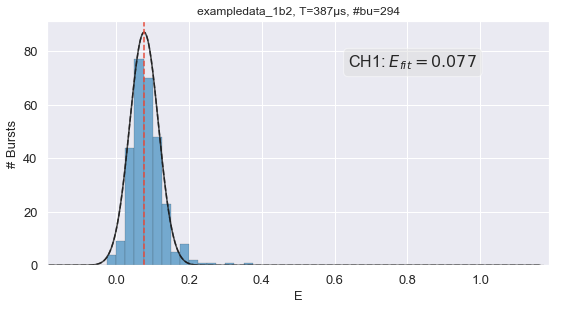

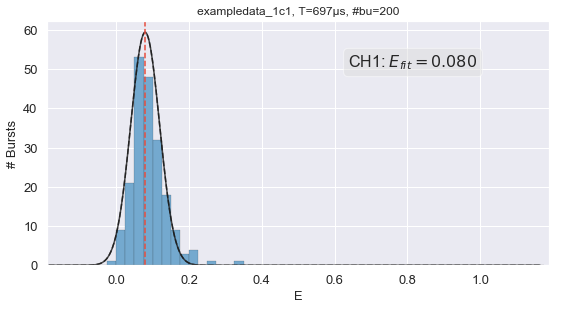

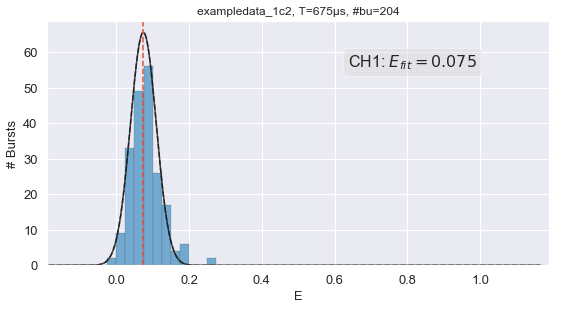

In [9]:
model = mfit.factory_gaussian()
alphas = []
for dset, dataset in zip(donlysets, datasets):
    dset.E_fitter.fit_histogram(model=model, verbose=False, pdf=False)
    dplot(dset, hist_fret, binwidth=0.025, show_model=True, pdf=False, show_fit_value=True, fit_from="center");
    params = dset.E_fitter.params
    Efit = params.to_dict()
    Centre = Efit['center']
    Edonly=Centre[0]
    Edonly
    alpha=Edonly/(1-Edonly)
    alphas.append(alpha)
    print(dataset.name+" alpha =", round(alpha, 4))

# Delta

Delta, or the direct excitation factor, describes the relative emission of the donor and acceptor under excitation of the donor laser, as a consequence of the blue tail of the acceptor absorption spectrum. It can be determined from the apparent stoichiometry of the acceptor only population.

You may want to alter the S2 threshold depending on where your doubly labelled population is in S.

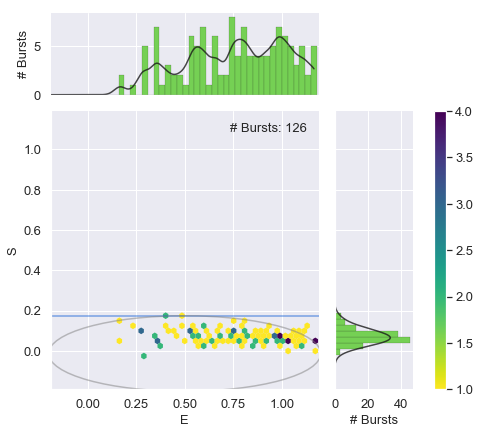

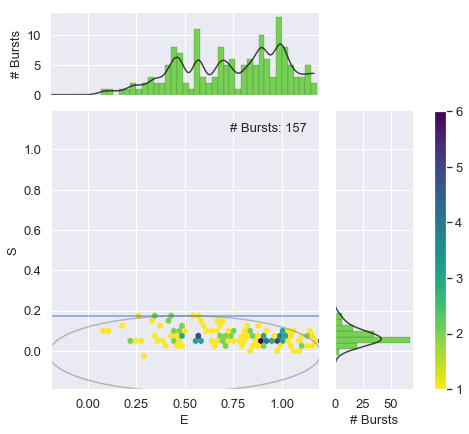

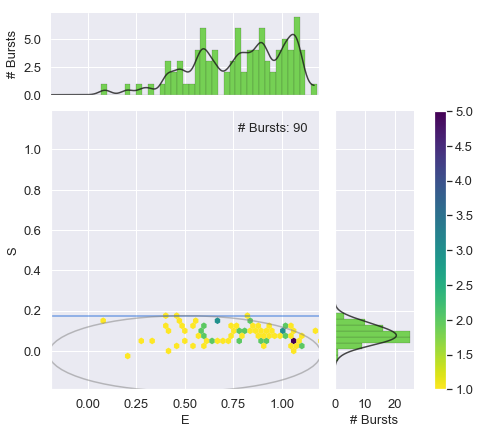

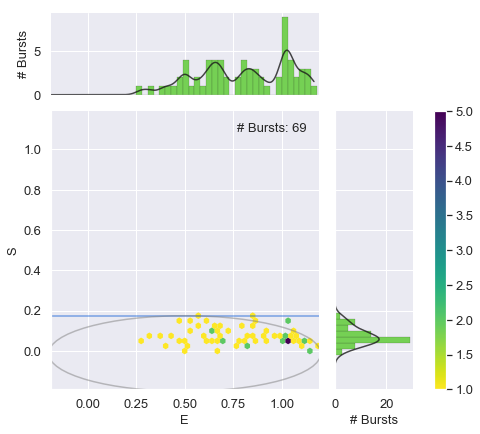

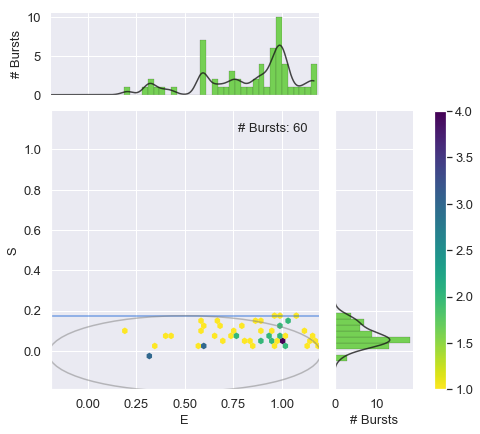

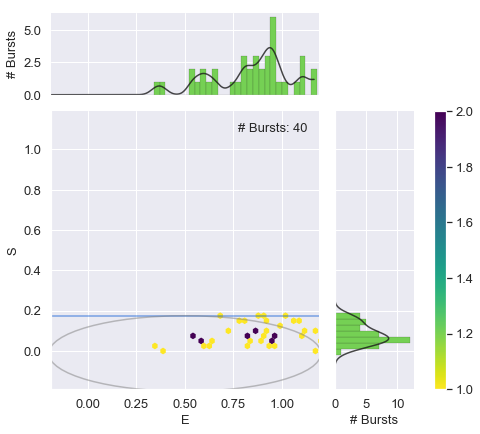

In [10]:
roi= dict(E1=-0.2, E2=1.2, S1=-0.2, S2=0.175, rect=True)
aonlysets = []
for burstset in burstsets:
    acceptoronly = burstset.select_bursts(select_bursts.ES, **roi)
    g = alex_jointplot(acceptoronly, cmap=colourscheme, marginal_color=20, vmax_fret=False)
    bpl.plot_ES_selection(g.ax_joint, **roi);
    aonlysets.append(acceptoronly)

This will extract delta, the direct excitation factor from the S histogram

exampledata_1a1 delta = 0.0714
exampledata_1a2 delta = 0.0643
exampledata_1b1 delta = 0.0864
exampledata_1b2 delta = 0.0631
exampledata_1c1 delta = 0.0622
exampledata_1c2 delta = 0.0727


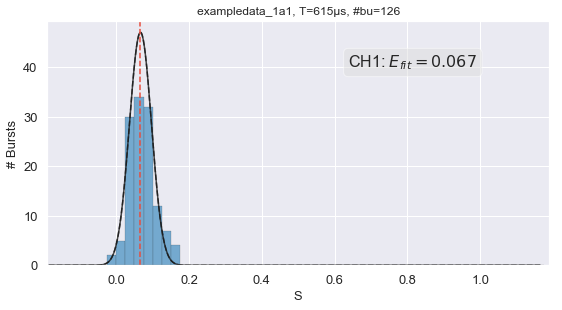

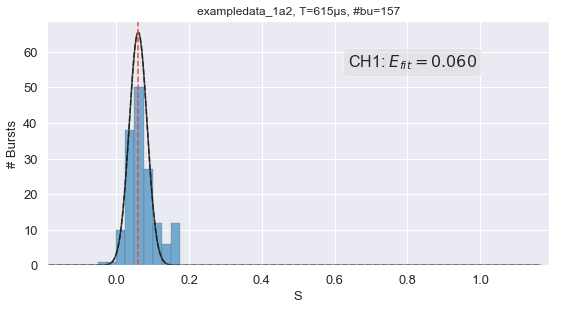

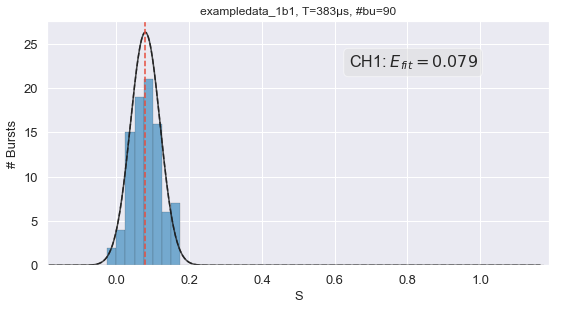

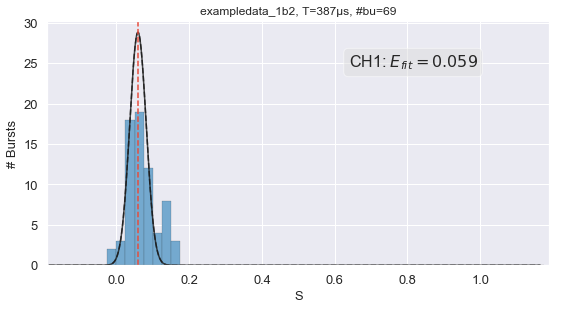

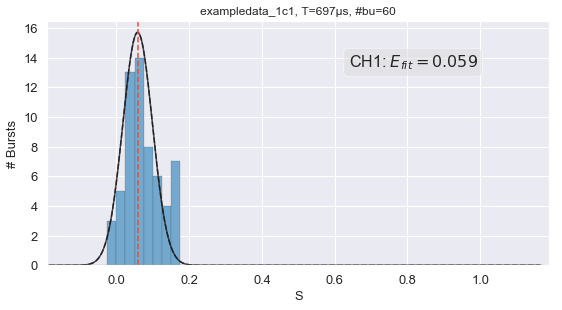

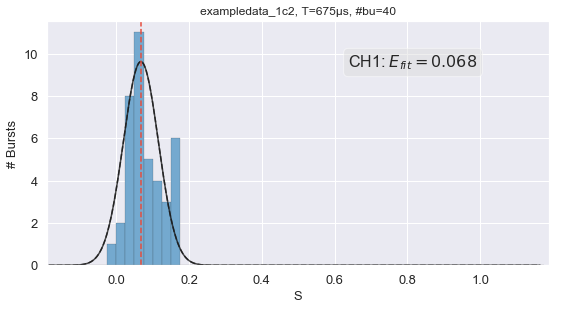

In [11]:
model = mfit.factory_gaussian()
deltas = []
for aset, dataset in zip(aonlysets, datasets):
    aset.S_fitter.fit_histogram(model=model, verbose=False, pdf=False)
    dplot(aset, hist_S, binwidth=0.025, show_model=True, pdf=False, show_fit_value=True, fit_from="center");
    aset.S_fitter.params
    params = aset.S_fitter.params
    Sfit = params.to_dict()
    Centre = Sfit['center']
    Saonly=Centre[0]
    delta=Saonly/(1-Saonly)
    deltas.append(delta)
    print(dataset.name+" delta =", round(delta, 4))

Correction factor summary:

In [12]:
for dataset, alpha in zip(datasets, alphas):
    print(dataset.name+" Alpha (lk factor)      = ", round(alpha, 5))
print(" ")
for dataset, delta in zip(datasets, deltas):
    print(dataset.name+" Delta (dir.ex factor)  = ", round(delta, 5))
print(" ")
print("Average Alpha =" , round(np.mean(alphas),5))
print("Average Delta =" , round(np.mean(deltas),5))

exampledata_1a1 Alpha (lk factor)      =  0.07281
exampledata_1a2 Alpha (lk factor)      =  0.07889
exampledata_1b1 Alpha (lk factor)      =  0.09006
exampledata_1b2 Alpha (lk factor)      =  0.08284
exampledata_1c1 Alpha (lk factor)      =  0.08637
exampledata_1c2 Alpha (lk factor)      =  0.08057
 
exampledata_1a1 Delta (dir.ex factor)  =  0.07138
exampledata_1a2 Delta (dir.ex factor)  =  0.06428
exampledata_1b1 Delta (dir.ex factor)  =  0.08635
exampledata_1b2 Delta (dir.ex factor)  =  0.06314
exampledata_1c1 Delta (dir.ex factor)  =  0.06216
exampledata_1c2 Delta (dir.ex factor)  =  0.07269
 
Average Alpha = 0.08193
Average Delta = 0.07
